In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import cm

In [2]:
import sys
print(sys.path) 
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/gcta/scripts')

['/data/cellardata/users/mpagadal/projects/germline-immune/cell-type-specificity/notebooks', '/nrnb/opt/anaconda3.7/lib/python37.zip', '/nrnb/opt/anaconda3.7/lib/python3.7', '/nrnb/opt/anaconda3.7/lib/python3.7/lib-dynload', '', '/cellar/users/mpagadal/.local/lib/python3.7/site-packages', '/nrnb/opt/anaconda3.7/lib/python3.7/site-packages', '/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/extensions', '/cellar/users/mpagadal/.ipython']


In [3]:
import networkx as nx
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import ndex2

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [6]:
import statsmodels.stats.multitest as multi
from adjustText import adjust_text

In [7]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import json

## Get GTEx summary statistics for immune microenvironment SNPs from all tissue types

### Run compile_gtex.sh 

script will extract variants of interact from GTEx summary statistics

In [8]:
with open('/cellar/users/mpagadal/Data/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl_dict = json.load(f)

In [9]:
ensembl_dict={k.split(".")[0]:v for k,v in ensembl_dict.items()}

In [10]:
def compile_gtex(directory,file_name,mapping):
    gtex_files=[x for x in os.listdir(directory)]
    total_gtex=pd.DataFrame()

    for x in gtex_files:
        cis=pd.read_csv(directory+x)
        cis["file"]=x.split(file_name)[0]
        total_gtex=total_gtex.append(cis)
    
    #format variant2 and gene
    total_gtex["variant2"]=total_gtex["variant_b37"].str.split("_").str[0]+":"+total_gtex["variant_b37"].str.split("_").str[1]+":"+total_gtex["variant_b37"].str.split("_").str[3]+":"+total_gtex["variant_b37"].str.split("_").str[2]
    #get gene ids for mapping
    total_gtex["gene_id"]=total_gtex["phenotype_id"].str.split(".").str[0]
    
    total_gtex["ref"]=total_gtex["variant_id"].str.split("_").str[2]
    total_gtex["alt"]=total_gtex["variant_id"].str.split("_").str[3]
    
    total_gtex_melt=pd.melt(total_gtex, id_vars=(["gene_id","slope","slope_se","ref","alt","file","pval_nominal","maf","tss_distance","variant_b37"]),value_vars=(["variant","variant2"]))
    
    total_gtex_melt["gene_name"]=total_gtex_melt["gene_id"].map(mapping)
    
    total_gtex_melt["assoc"]=total_gtex_melt["value"]+"_"+total_gtex_melt["gene_name"]
    
    return(total_gtex_melt)

In [11]:
gtex=compile_gtex("/cellar/users/mpagadal/Data/gtex/extracted_snps/",".snps.csv",ensembl_dict)

In [12]:
print(gtex.shape)
gtex.head()

(1549580, 14)


,gene_id,slope,slope_se,ref,alt,file,pval_nominal,maf,tss_distance,variant_b37,variable,value,gene_name,assoc
0,ENSG00000237094,0.471558,0.461462,G,A,Kidney_Cortex,0.312301,0.053846,984755,1_1421752_G_A_b37,variant,1:1421752:G:A,RP4-669L17.10,1:1421752:G:A_RP4-669L17.10
1,ENSG00000225972,0.571838,0.349512,G,A,Kidney_Cortex,0.108794,0.053846,857310,1_1421752_G_A_b37,variant,1:1421752:G:A,MTND1P23,1:1421752:G:A_MTND1P23
2,ENSG00000225630,0.803202,0.276528,G,A,Kidney_Cortex,0.005682,0.053846,856732,1_1421752_G_A_b37,variant,1:1421752:G:A,MTND2P28,1:1421752:G:A_MTND2P28
3,ENSG00000237973,0.565607,0.339045,G,A,Kidney_Cortex,0.102213,0.053846,855298,1_1421752_G_A_b37,variant,1:1421752:G:A,RP5-857K21.6,1:1421752:G:A_RP5-857K21.6
4,ENSG00000229344,0.493088,0.346081,G,A,Kidney_Cortex,0.161121,0.053846,853615,1_1421752_G_A_b37,variant,1:1421752:G:A,RP5-857K21.7,1:1421752:G:A_RP5-857K21.7


## Get TCGA summary statistics for immune microenvironment SNPs for all cancer types

In [13]:
snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")
snps["assoc"]=snps["snps"]+"_"+snps["file"]

In [14]:
#map to minor allele frequency
mp_maf=dict(zip(snps["snps"],snps["maf"]))

In [15]:
#snps found in gtex
gtex=gtex[gtex["value"].isin(snps["snps"].tolist())]

In [16]:
gtex_snps=len(gtex["value"].unique().tolist())
all_snps=len(snps["snps"].unique().tolist())
print(gtex_snps)
print(all_snps)

446
475


In [17]:
"The following snps were not found {}".format(" ".join(snps[~snps["snps"].isin(gtex["value"].tolist())]["snps"].tolist()))

'The following snps were not found 5:69733811:T:C 19:54856354:G:A 19:54861175:G:A 19:54861462:G:T 19:54793198:G:C 19:54783035:T:G 19:54749474:T:G 5:96206416:G:T 5:96225449:G:A 5:96357030:G:T 5:96326397:T:G 6:32605437:G:C 6:32624038:C:T 5:80203678:A:C 15:45363341:G:A 19:55025471:C:A 11:65504069:A:C 1:89477830:T:C 3:48516525:A:T 5:96039895:G:T 5:96152809:A:G 10:97359625:T:C 5:79927651:G:A 5:79951030:G:A 5:96201579:A:C 5:96324943:G:T 12:8214856:A:C 7:153338633:G:A 2:212571330:A:C'

### See how many snps were found

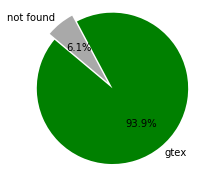

In [18]:
f=plt.figure(figsize=(3,3))
labels = 'gtex', 'not found'
sizes = [gtex_snps/all_snps,(1-(gtex_snps/all_snps))]
colors = ['green', 'darkgray']
explode = (0.1, 0.0)  # explode 1st slice
mpl.rcParams['font.size'] = 10
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=140)
plt.axis('equal')
f.savefig("../plots/gtex.snps.found.pdf")

### See how many gene ids were not mapped

In [19]:
#how many gene ids were not mapped
print("{} gene ids were not mapped".format(len(gtex[gtex["gene_name"].isnull()]["gene_id"].unique().tolist())))
#remove rows for which gene name was not mapped
gtex=gtex[~(gtex["gene_name"].isnull())]

34 gene ids were not mapped


In [20]:
#rename columns
gtex.columns=["gene_id","gtex slope","gtex slope_se","ref","alt","gtex cell_type","pval","gtex maf","tss_distance","variant id","variable","snps","gtex file","assoc"]

In [21]:
del gtex["assoc"]

### make dataframe with gtex and tcga information

In [22]:
snps_gtex=pd.merge(gtex,snps,on=["snps"],how="left")

In [23]:
#switch gtex beta if alt allele do not align
snps_gtex["gtex slope"]=np.where(snps_gtex["alt"] != snps_gtex["ALT"], (snps_gtex["gtex slope"]*-1),snps_gtex["gtex slope"])

In [24]:
#export results
snps_gtex.to_csv("../data/gtex_variant_information.tsv",sep="\t")

### make cis and trans dataframes

In [25]:
#make cis and trans dataframes
snps_gtex_cis=snps_gtex[snps_gtex["gtex file"]==snps_gtex["file"]]
snps_gtex_trans=snps_gtex[snps_gtex["gtex file"]!=snps_gtex["file"]]

In [26]:
cis_trans=len(snps_gtex_trans[snps_gtex_trans["assoc"].isin(snps_gtex_cis["assoc"].tolist())]["assoc"].unique())
trans=len(snps_gtex_trans[~snps_gtex_trans["assoc"].isin(snps_gtex_cis["assoc"].tolist())]["assoc"].unique())
cis=len(snps_gtex_cis[~snps_gtex_cis["assoc"].isin(snps_gtex_trans["assoc"].tolist())]["assoc"].unique())
notfound=len(snps[~snps["assoc"].isin(snps_gtex["assoc"].tolist())])

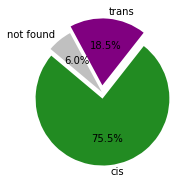

In [27]:
f=plt.figure(figsize=(3,3))
labels = 'cis','trans','not found'
sizes = [cis_trans/len(snps),trans/len(snps), notfound/len(snps)]
colors = ['forestgreen', 'purple','silver']
explode = (0.1, 0.1,0)  # explode 1st slice
mpl.rcParams['font.size'] = 10
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=140)
plt.axis('equal')
f.savefig("../plots/gtex.cis.trans.pdf")

## Get sample sizes for tissues

In [28]:
tissue_num=pd.read_csv("/cellar/users/mpagadal/Data/gtex/GTEx.tissue.sample.size.csv")

In [29]:
tissue_num["Tissue"]=tissue_num["Tissue"].str.replace("- ","")
tissue_num["Tissue"]=tissue_num["Tissue"].str.replace(" ","_")
tissue_num["Tissue"]=tissue_num["Tissue"].str.replace("(","")
tissue_num["Tissue"]=tissue_num["Tissue"].str.replace(")","")

In [30]:
mp_num=dict(zip(tissue_num["Tissue"],tissue_num["# RNASeq and Genotyped samples"]))

In [31]:
#map number of samples per cell type
snps_gtex_cis["number"]=snps_gtex_cis["gtex cell_type"].map(mp_num)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Get mapping between gtex/tcga tissues

In [32]:
#get tissue mappings
tissue_mapping=pd.read_csv("../data/gtex.tcga.tissue.csv")
tissue_mapping["combo"]=tissue_mapping["gtex tissues"]+"."+tissue_mapping["TCGA"]

In [33]:
tissue_mapping["whole_blood combo"]="Whole_Blood"+"."+tissue_mapping["TCGA"]

In [34]:
tissue_mapping.head()

,gtex tissues,TCGA,combo,whole_blood combo
0,Small_Intestine_Terminal_Ileum,COAD,Small_Intestine_Terminal_Ileum.COAD,Whole_Blood.COAD
1,Kidney_Cortex,KIRP,Kidney_Cortex.KIRP,Whole_Blood.KIRP
2,Kidney_Cortex,KICH,Kidney_Cortex.KICH,Whole_Blood.KICH
3,Kidney_Cortex,KIRC,Kidney_Cortex.KIRC,Whole_Blood.KIRC
4,Testis,TGCT,Testis.TGCT,Whole_Blood.TGCT


## PCA analysis of different cell types

In [35]:
#make dataframe for pca analysis
df_cell=snps_gtex_cis.pivot(index="gtex cell_type",columns="assoc",values="gtex slope")
df_cell=df_cell.fillna(0) #if missing, fill value with 0

In [36]:
df_cell=df_cell[df_cell.index.isin(tissue_mapping["gtex tissues"].tolist()+["Whole_Blood"])]

In [37]:
scaler=StandardScaler()
scaler.fit(df_cell)
X_scaled=scaler.transform(df_cell)

In [38]:
pca = PCA(n_components=10)

In [39]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [40]:
mp_variance={}

for i,val in enumerate(pca.explained_variance_ratio_.tolist()):
    key="PC"+str(i+1)
    mp_variance[key]=val

In [41]:
X_pca=pca.transform(X_scaled)

In [42]:
df=pd.DataFrame(X_pca)
df.index=df_cell.index
df.columns=["PC"+str(x+1) for x in df.columns]

In [43]:
df["num"]=df.index.map(mp_num)

In [44]:
x="PC1"
y="PC2"

In [45]:
df=df.sort_values(by="PC1")

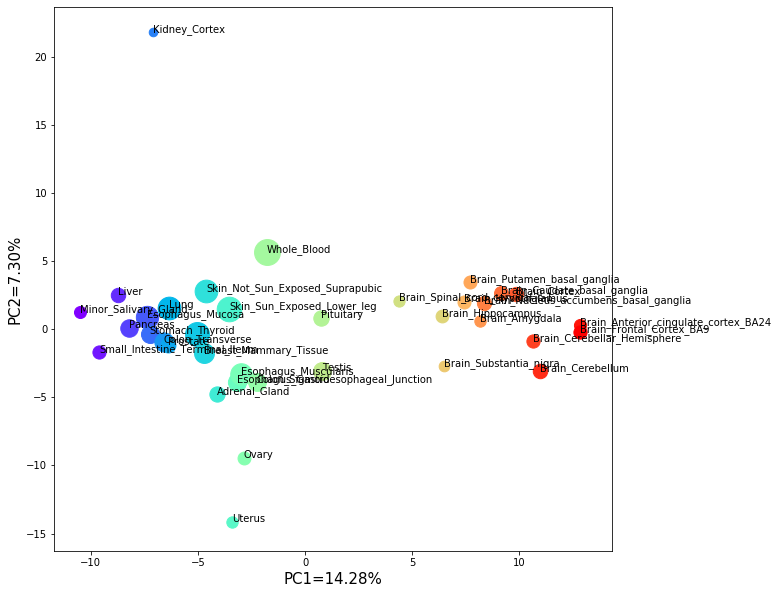

In [46]:
f=plt.figure(figsize=(10,10))

n=df.index.unique()
color=iter(cm.rainbow(np.linspace(0,1,len(n))))

for t, c in zip(n, color):
    plt.scatter(df[df.index==t][x].values[0], df[df.index==t][y].values[0], s=df[df.index==t]["num"].values[0], color=c)

for i, row in df.iterrows():
    plt.annotate(i, (row[x], row[y]))

plt.xlabel(x+"="+"{0:.2f}%".format(mp_variance[x]*100),fontsize=15)
plt.ylabel(y+"="+"{0:.2f}%".format(mp_variance[y]*100),fontsize=15)
f.savefig("../plots/gtex.pca.pdf")

## Plot QQ plot

In [47]:
def ppoints(n, a):
    """ numpy analogue or `R`'s `ppoints` function
        see details at http://stat.ethz.ch/R-manual/R-patched/library/stats/html/ppoints.html 
        :param n: array type or number"""
    try:
        n = np.float(len(n))
    except TypeError:
        n = np.float(n)
    return (np.arange(n) + 1 - a)/(n + 1 - 2*a)

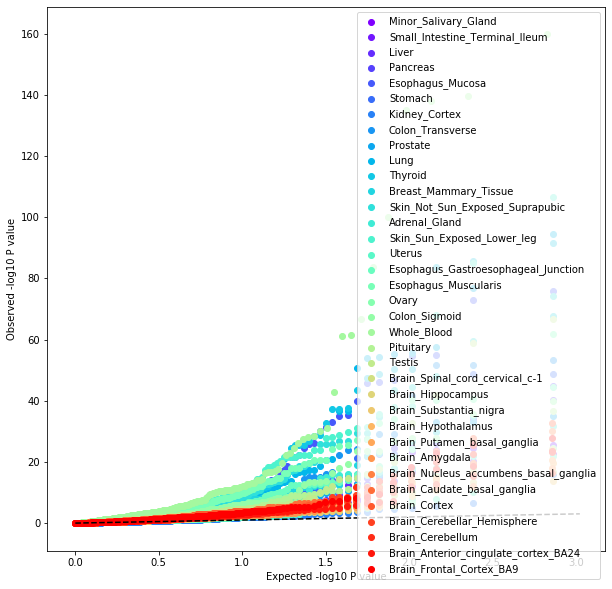

In [48]:
color=iter(cm.rainbow(np.linspace(0,1,len(n))))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for x in n:
    p_values=snps_gtex_cis[snps_gtex_cis["gtex cell_type"]==x].sort_values(by="pval")["pval"].tolist()
    c=next(color)
    plt.scatter(-np.log10(ppoints(len(p_values), 1./2)), -np.log10(p_values),label=x,color=c)
ax.plot([0,ax.get_xlim()[1]], [0,ax.get_xlim()[1]], ls="--", c="k")
ax.set_xlabel("Expected -log10 P value")
ax.set_ylabel('Observed -log10 P value')
plt.legend()
fig.savefig('../plots/gtex.qq.pdf')


In [58]:
tissue=snps_gtex_cis.pivot(index="assoc",columns="gtex cell_type",values="gtex slope")

In [59]:
tissue=tissue.fillna(0)

In [60]:
tissue=tissue.T

<Figure size 1440x1440 with 0 Axes>

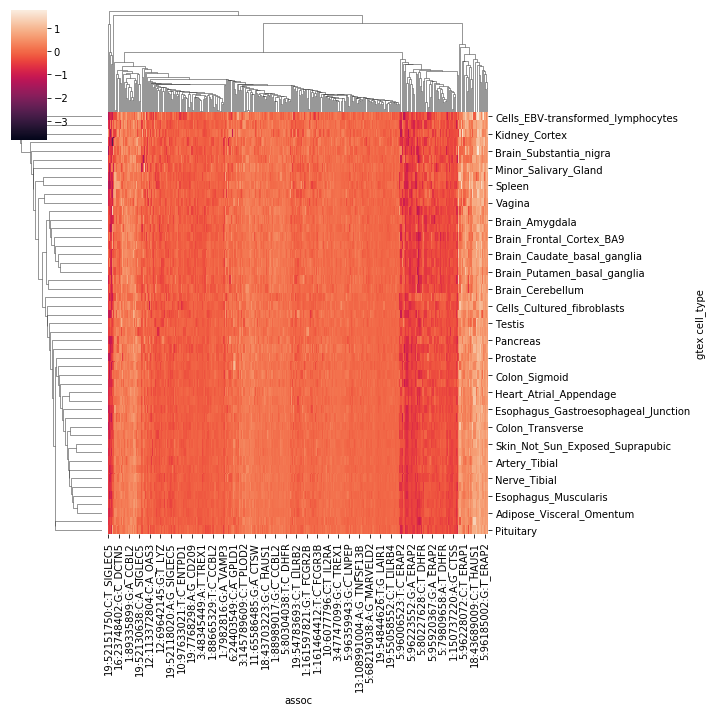

In [67]:
f=plt.figure(figsize=(20,20))
ax=sns.clustermap(tissue)

In [69]:
tissue_test=tissue.loc[["Brain_Cortex","Breast_Mammary_Tissue"]]

In [70]:
tissue_test=tissue_test.T

In [79]:
tissue_test["difference"]=tissue_test["Brain_Cortex"]-tissue_test["Breast_Mammary_Tissue"]

In [80]:
tissue_test=tissue_test.sort_values(by="difference")

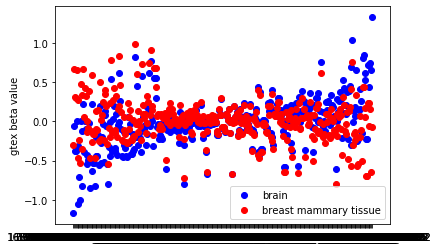

In [83]:
plt.scatter(tissue_test.index.tolist(),tissue_test["Brain_Cortex"].tolist(),color="blue",label="brain")
plt.scatter(tissue_test.index.tolist(),tissue_test["Breast_Mammary_Tissue"].tolist(),color="red",label="breast mammary tissue")
plt.ylabel("gtex beta value")
plt.legend()

In [84]:
tissue

assoc,10:6077796:C:T_IL2RA,10:6095928:C:A_IL2RA,10:75607168:T:C_SEC24C,10:97603163:G:A_ENTPD1,10:97630523:T:C_ENTPD1,10:97633021:T:C_ENTPD1,11:10490415:T:C_AMPD3,11:60103112:T:C_MS4A4A,11:64885445:C:A_CTSW,11:64908332:A:C_CTSW,...,6:159042876:C:A_DYNLT1,6:159072350:C:T_DYNLT1,6:160272430:C:T_IGF2R,6:160511354:G:A_IGF2R,6:24403549:C:A_GPLD1,6:24474335:C:G_GPLD1,6:24560002:A:T_GPLD1,7:6067019:A:C_EIF2AK1,8:11309400:C:T_FAM167A,9:127095703:G:A_PSMB7
gtex cell_type,,,,,,,,,,,,,,,,,,,,,
Adipose_Subcutaneous,0.214186,0.592003,0.121819,0.011570,-0.048113,-0.052280,0.248476,0.120238,0.038116,-0.142123,...,0.194109,-0.245483,0.183401,0.090160,0.170900,0.115352,0.016010,-0.102954,-0.143770,-0.077955
Adipose_Visceral_Omentum,0.102967,0.419156,0.067498,0.031962,-0.017071,-0.012242,0.095245,0.073679,0.169572,-0.128182,...,0.161332,-0.216332,-0.121536,0.055048,0.206663,0.048400,0.003702,-0.100460,-0.050569,-0.165650
Adrenal_Gland,0.162306,0.520406,0.041263,-0.067988,0.002276,0.004544,0.138521,0.105490,-0.046242,-0.353951,...,0.391024,-0.569594,-0.027016,0.107976,0.094504,0.018970,0.068893,-0.280687,0.042469,0.199814
Artery_Aorta,0.055277,0.291532,0.045286,0.050893,-0.076166,-0.076461,0.169344,0.092164,0.139008,-0.092482,...,-0.114649,0.077967,0.324482,0.243379,0.229029,-0.174559,-0.054109,-0.152341,-0.249461,0.027684
Artery_Coronary,0.026545,0.312275,0.001209,0.017563,-0.041424,-0.035299,0.163717,0.143338,0.162614,-0.232527,...,0.094597,-0.133729,0.171479,0.190007,0.306828,0.142258,0.130738,-0.080261,-0.020872,0.123221
Artery_Tibial,0.111730,0.312529,-0.016389,-0.024329,0.000685,0.001859,0.186565,0.113623,0.040712,-0.143730,...,0.136619,-0.195008,0.088827,0.183849,0.417752,0.184988,0.123517,-0.164202,0.000000,-0.031749
Brain_Amygdala,0.000000,0.000000,0.024138,0.077768,-0.246478,-0.246478,0.550128,0.108366,0.063270,-0.006449,...,0.112356,-0.026979,0.169663,0.062488,0.305818,0.170170,0.068031,-0.160049,0.173479,-0.159383
Brain_Anterior_cingulate_cortex_BA24,0.000000,0.000000,0.063440,0.126058,-0.286222,-0.286222,0.329180,0.098439,0.081605,-0.048675,...,0.056593,-0.079082,-0.135858,0.054506,0.191818,0.052575,-0.057786,-0.434383,0.064433,0.097551
Brain_Caudate_basal_ganglia,0.000000,0.000000,-0.034647,0.081059,-0.192144,-0.192144,0.425145,0.203596,0.172721,0.140746,...,-0.023120,-0.018095,-0.089233,0.016980,0.206541,-0.117333,-0.101307,-0.412675,0.131890,-0.005585


## Get TCGA association analyses by cancer for each RNA processing pipeline

In [78]:
tpm_cancer=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/tpm.cancer.tsv",delimiter="\t")
firebrowse_cancer=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/firebrowse.cancer.tsv",delimiter="\t")
pancanatlas_cancer=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/pancanatlas.cancer.tsv",delimiter="\t")

## See concordance between associations

In [53]:
def make_bootstrapping_df(df,name,combos):
    compare_beta=pd.merge(snps_gtex_cis,df,on="assoc")
    compare_beta["combo"]=compare_beta["gtex cell_type"]+"."+compare_beta["file_name"]
    if combos == "regular":
        compare_beta=compare_beta[compare_beta["combo"].isin(tissue_mapping["combo"].tolist())]
    if combos == "blood":
        compare_beta=compare_beta[compare_beta["combo"].isin(tissue_mapping["whole_blood combo"].tolist())]
    
    compare_beta["z_score"]=(compare_beta["gtex slope"]-compare_beta["BETA"])/compare_beta["gtex slope_se"]
    
    for x in compare_beta["combo"].unique():
        test=compare_beta[compare_beta["combo"]==x]
        test["z_score"]=abs(test["z_score"])
        test.to_csv(name+"."+x+".csv")
    
    

In [54]:
make_bootstrapping_df(tpm_cancer,"/cellar/users/mpagadal/Data/gtex/for_bootstrapping/brian_bootstrap/brian.test","regular")
make_bootstrapping_df(firebrowse_cancer,"/cellar/users/mpagadal/Data/gtex/for_bootstrapping/firebrowse_bootstrap/firebrowse.test","regular")
make_bootstrapping_df(pancanatlas_cancer,"/cellar/users/mpagadal/Data/gtex/for_bootstrapping/pancanatlas_bootstrap/pancanatlas.test","regular")

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [55]:
make_bootstrapping_df(tpm_cancer,"/cellar/users/mpagadal/Data/gtex/for_bootstrapping/brian_bootstrap/brian.test","blood")
make_bootstrapping_df(firebrowse_cancer,"/cellar/users/mpagadal/Data/gtex/for_bootstrapping/firebrowse_bootstrap/firebrowse.test","blood")
make_bootstrapping_df(pancanatlas_cancer,"/cellar/users/mpagadal/Data/gtex/for_bootstrapping/pancanatlas_bootstrap/pancanatlas.test","blood")

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


## Get dataframe from bootstrapping

In [63]:
def make_deviant_df(directory,name,threshold):
    files=[x for x in os.listdir(directory) if "bootstrap" in x]
    
    deviant=pd.DataFrame()

    for x in files:
        boot=pd.read_csv(directory+"/"+x)
        df=boot[boot["bootstrap p"]<threshold]
        deviant=deviant.append(df)
        
    return(deviant)
    

In [69]:
brian_deviant=make_deviant_df("/cellar/users/mpagadal/Data/gtex/for_bootstrapping/brian_bootstrap","brian",.01)
firebrowse_deviant=make_deviant_df("/cellar/users/mpagadal/Data/gtex/for_bootstrapping/firebrowse_bootstrap","firebrowse",.01)
pancanatlas_deviant=make_deviant_df("/cellar/users/mpagadal/Data/gtex/for_bootstrapping/pancanatlas_bootstrap","pancanatlas",.01)

In [70]:
brian_immune_deviant=brian_deviant[brian_deviant["gtex cell_type"]=="Whole_Blood"]
brian_match_deviant=brian_deviant[brian_deviant["gtex cell_type"]!="Whole_Blood"]

In [71]:
firebrowse_immune_deviant=firebrowse_deviant[firebrowse_deviant["gtex cell_type"]=="Whole_Blood"]
firebrowse_match_deviant=firebrowse_deviant[firebrowse_deviant["gtex cell_type"]!="Whole_Blood"]

In [72]:
pancanatlas_immune_deviant=pancanatlas_deviant[pancanatlas_deviant["gtex cell_type"]=="Whole_Blood"]
pancanatlas_match_deviant=pancanatlas_deviant[pancanatlas_deviant["gtex cell_type"]!="Whole_Blood"]

In [73]:
pancanatlas_match_deviant

,Unnamed: 0,Unnamed: 0.1,gene_id,gtex slope,gtex slope_se,ref,alt,gtex cell_type,pval,gtex maf,...,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,pheno,combo,z_score,bootstrap p
32,32,47202,ENSG00000163131,0.516874,0.071880,C,T,Brain_Cerebellar_Hemisphere,6.566587e-11,0.423567,...,430,0.115477,0.068827,1.677780,9.414030e-02,.,CTSS,Brain_Cerebellar_Hemisphere.LGG,5.584259,0.004191
33,33,48672,ENSG00000163131,0.481948,0.070521,G,A,Brain_Cerebellar_Hemisphere,3.951236e-10,0.410828,...,430,0.102251,0.069174,1.478170,1.401200e-01,.,CTSS,Brain_Cerebellar_Hemisphere.LGG,5.384196,0.004185
34,34,50142,ENSG00000163131,0.481948,0.070521,T,C,Brain_Cerebellar_Hemisphere,3.951236e-10,0.410828,...,430,0.102251,0.069174,1.478170,1.401200e-01,.,CTSS,Brain_Cerebellar_Hemisphere.LGG,5.384196,0.004448
115,115,167682,ENSG00000164307,0.145819,0.053531,A,G,Brain_Cerebellar_Hemisphere,7.438915e-03,0.261147,...,430,-0.414737,0.080152,-5.174400,3.563980e-07,.,ERAP1,Brain_Cerebellar_Hemisphere.LGG,10.471535,0.000000
121,121,176502,ENSG00000164307,-0.024520,0.063306,T,C,Brain_Cerebellar_Hemisphere,6.992208e-01,0.194268,...,430,-0.339840,0.097212,-3.495840,5.233970e-04,.,ERAP1,Brain_Cerebellar_Hemisphere.LGG,4.980887,0.006497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,136,199645,ENSG00000164308,0.438607,0.261923,G,A,Testis,9.545377e-02,0.016544,...,108,NaN,NaN,NaN,NaN,"CONST_ALLELE,REF",ERAP2,Testis.TGCT,NaN,0.000000
156,156,229045,ENSG00000164308,-0.463646,0.239539,A,G,Testis,5.421258e-02,0.025735,...,108,NaN,NaN,NaN,NaN,"CONST_ALLELE,REF",ERAP2,Testis.TGCT,NaN,0.000000
280,280,409795,ENSG00000167613,-0.067293,0.111285,G,A,Testis,5.460112e-01,0.040441,...,108,-1.523610,0.962937,-1.582260,1.169150e-01,.,LAIR1,Testis.TGCT,13.086401,0.008327
314,314,459175,ENSG00000145416,0.523876,0.036382,G,A,Testis,1.760040e-33,0.397059,...,108,0.013029,0.133533,0.097571,9.224790e-01,.,MARCH1,Testis.TGCT,14.041245,0.008415


In [74]:
consensus_deviant=pd.DataFrame()

for x in brian_match_deviant["combo"].unique():
    df=brian_match_deviant[brian_match_deviant["combo"]==x]
    
    fire=firebrowse_match_deviant[firebrowse_match_deviant["combo"]==x]["assoc"].tolist()
    pancan=pancanatlas_match_deviant[pancanatlas_match_deviant["combo"]==x]["assoc"].tolist()
    
    df["firebrowse_support"]=np.where(df["assoc"].isin(fire),1,0)
    df["pancan_support"]=np.where(df["assoc"].isin(pancan),1,0)
    
    consensus_deviant=consensus_deviant.append(df)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [75]:
consensus_immune=pd.DataFrame()

for x in brian_immune_deviant["combo"].unique():
    df=brian_immune_deviant[brian_immune_deviant["combo"]==x]
    
    fire=firebrowse_immune_deviant[firebrowse_immune_deviant["combo"]==x]["assoc"].tolist()
    pancan=pancanatlas_immune_deviant[pancanatlas_immune_deviant["combo"]==x]["assoc"].tolist()
    
    df["firebrowse_support"]=np.where(df["assoc"].isin(fire),1,0)
    df["pancan_support"]=np.where(df["assoc"].isin(pancan),1,0)
    
    consensus_immune=consensus_immune.append(df)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [76]:
consensus_deviant["sum"]=consensus_deviant["firebrowse_support"]+consensus_deviant["pancan_support"]
consensus_immune["sum"]=consensus_immune["firebrowse_support"]+consensus_immune["pancan_support"]

In [77]:
consensus_deviant=consensus_deviant[(consensus_deviant["sum"]>0)]
consensus_deviant=consensus_deviant[~(consensus_deviant["z_score"].isnull())]

In [78]:
consensus_immune=consensus_immune[(consensus_immune["sum"]>0)]
consensus_immune=consensus_immune[~(consensus_immune["z_score"].isnull())]

In [79]:
consensus_immune

,Unnamed: 0,Unnamed: 0.1,gene_id,gtex slope,gtex slope_se,ref,alt,gtex cell_type,pval,gtex maf,...,T_STAT,P,ERRCODE,pheno,combo,z_score,bootstrap p,firebrowse_support,pancan_support,sum
189,189,312283,ENSG00000090382,-0.733674,0.017838,T,C,Whole_Blood,1.043525e-160,0.490143,...,-2.832170,5.237760e-03,.,LYZ,Whole_Blood.LIHC,23.898710,0.000000,1,1,2
197,197,324043,ENSG00000132965,0.201135,0.016874,A,T,Whole_Blood,6.299968e-29,0.254480,...,-0.804018,4.226180e-01,.,ALOX5AP,Whole_Blood.LIHC,17.698141,0.009504,1,1,2
314,314,498253,ENSG00000172543,-0.321170,0.016645,A,G,Whole_Blood,4.548993e-62,0.195341,...,-5.636230,7.999690e-08,.,CTSW,Whole_Blood.LIHC,19.932937,0.009831,1,1,2
315,315,499723,ENSG00000172543,-0.322041,0.016673,C,A,Whole_Blood,3.647897e-62,0.194444,...,-5.636230,7.999690e-08,.,CTSW,Whole_Blood.LIHC,19.847493,0.009920,1,1,2
317,317,502663,ENSG00000171860,-0.757753,0.020938,A,G,Whole_Blood,2.799990e-140,0.314516,...,-0.836885,4.039460e-01,.,C3AR1,Whole_Blood.LIHC,31.697022,0.000000,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,232,375041,ENSG00000105501,-0.233404,0.030640,G,C,Whole_Blood,1.352654e-13,0.180108,...,5.603190,7.309590e-08,.,SIGLEC5,Whole_Blood.KIRP,28.975503,0.002516,1,1,2
235,235,379391,ENSG00000171051,-0.000051,0.014088,A,C,Whole_Blood,9.971125e-01,0.312724,...,1.901880,5.869930e-02,.,FPR1,Whole_Blood.KIRP,14.998376,0.009861,1,1,2
317,317,502661,ENSG00000171860,-0.757753,0.020938,A,G,Whole_Blood,2.799990e-140,0.314516,...,0.412456,6.804700e-01,.,C3AR1,Whole_Blood.KIRP,38.396332,0.000000,1,1,2
318,318,504131,ENSG00000171860,-0.756348,0.021118,A,G,Whole_Blood,1.125281e-138,0.313620,...,0.368962,7.125670e-01,.,C3AR1,Whole_Blood.KIRP,37.796634,0.000000,1,1,2


## Keep only combos with least deviants

In [80]:
select=consensus_deviant["combo"].value_counts().reset_index()

In [81]:
select["cancer"]=select["index"].str.split(".").str[-1]
select["gtex"]=select["index"].str.split(".").str[0]

In [82]:
combos=[]

for x in select["cancer"].unique():
    df=select[select["cancer"]==x]
    combos.append(df[df["combo"]==df["combo"].min()]["index"].values[0])

## Get brian comparison

In [83]:
compare_beta=pd.merge(snps_gtex_cis,tpm_cancer,on="assoc")
compare_beta["combo"]=compare_beta["gtex cell_type"]+"."+compare_beta["file_name"]
compare_beta["z_score"]=(compare_beta["gtex slope"]-compare_beta["BETA"])/compare_beta["gtex slope_se"]

In [84]:
compare_beta.head()

,gene_id,gtex slope,gtex slope_se,ref,alt,gtex cell_type,pval,gtex maf,tss_distance,variant id,...,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,pheno,combo,z_score
0,ENSG00000049245,0.230936,0.10345,G,A,Kidney_Cortex,0.030614,0.176923,10001,1_7841330_G_A_b37,...,ADD,70,0.168077,0.276697,0.607441,0.546014,.,VAMP3,Kidney_Cortex.ACC,0.607627
1,ENSG00000049245,0.230936,0.10345,G,A,Kidney_Cortex,0.030614,0.176923,10001,1_7841330_G_A_b37,...,ADD,322,0.225966,0.123493,1.829790,0.068248,.,VAMP3,Kidney_Cortex.BLCA,0.048045
2,ENSG00000049245,0.230936,0.10345,G,A,Kidney_Cortex,0.030614,0.176923,10001,1_7841330_G_A_b37,...,ADD,788,0.136816,0.074679,1.832070,0.067325,.,VAMP3,Kidney_Cortex.BRCA,0.909811
3,ENSG00000049245,0.230936,0.10345,G,A,Kidney_Cortex,0.030614,0.176923,10001,1_7841330_G_A_b37,...,ADD,176,0.188130,0.180666,1.041310,0.299274,.,VAMP3,Kidney_Cortex.CESC,0.413786
4,ENSG00000049245,0.230936,0.10345,G,A,Kidney_Cortex,0.030614,0.176923,10001,1_7841330_G_A_b37,...,ADD,30,0.075788,0.441491,0.171664,0.865854,.,VAMP3,Kidney_Cortex.CHOL,1.499736


In [85]:
compare_beta=compare_beta[compare_beta["combo"].isin(combos)]
compare_beta=compare_beta[compare_beta["assoc"].isin(snps["assoc"].tolist())]

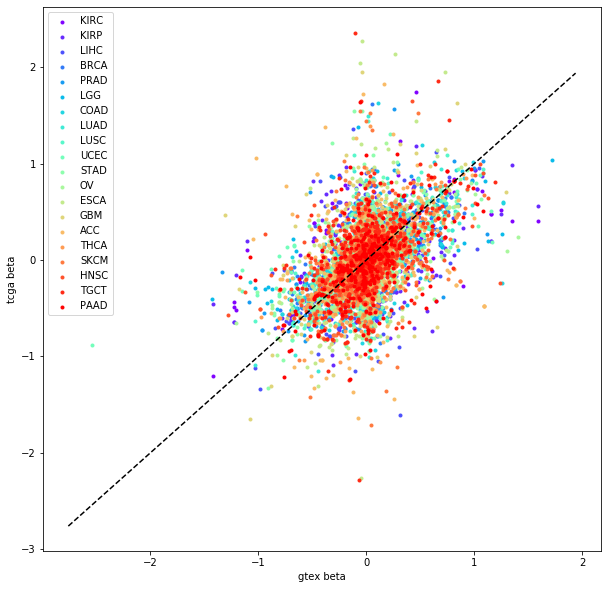

In [86]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

n=compare_beta["file_name"].unique()
color=iter(cm.rainbow(np.linspace(0,1,len(n))))

for x in n:
    c=next(color)
    canc_filt_dev=compare_beta[compare_beta["file_name"]==x]
    plt.scatter(canc_filt_dev["gtex slope"],canc_filt_dev["BETA"],color=c,marker=".",label=x)


ax.set_xlabel("gtex beta")
ax.plot([ax.get_xlim()[0],ax.get_xlim()[1]], [ax.get_xlim()[0],ax.get_xlim()[1]], ls="--", c="k")
ax.set_ylabel("tcga beta")
plt.legend()
fig.savefig('gtex.beta.pdf')

In [87]:
compare_beta

,gene_id,gtex slope,gtex slope_se,ref,alt,gtex cell_type,pval,gtex maf,tss_distance,variant id,...,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,pheno,combo,z_score
10,ENSG00000049245,0.230936,0.103450,G,A,Kidney_Cortex,3.061431e-02,0.176923,10001,1_7841330_G_A_b37,...,ADD,418,0.182127,0.111590,1.632110,0.103436,.,VAMP3,Kidney_Cortex.KIRC,0.471814
11,ENSG00000049245,0.230936,0.103450,G,A,Kidney_Cortex,3.061431e-02,0.176923,10001,1_7841330_G_A_b37,...,ADD,204,0.194364,0.156992,1.238050,0.217225,.,VAMP3,Kidney_Cortex.KIRP,0.353525
43,ENSG00000049245,0.172823,0.084241,G,A,Liver,4.210626e-02,0.148876,10001,1_7841330_G_A_b37,...,ADD,169,0.169693,0.186139,0.911651,0.363368,.,VAMP3,Liver.LIHC,0.037160
62,ENSG00000049245,0.106642,0.028678,G,A,Breast_Mammary_Tissue,2.428957e-04,0.133739,10001,1_7841330_G_A_b37,...,ADD,788,0.136816,0.074679,1.832070,0.067325,.,VAMP3,Breast_Mammary_Tissue.BRCA,-1.052165
200,ENSG00000049245,0.313503,0.047852,G,A,Prostate,9.748448e-10,0.154696,10001,1_7841330_G_A_b37,...,ADD,401,0.369310,0.101037,3.655200,0.000292,.,VAMP3,Prostate.PRAD,-1.166240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530216,ENSG00000160255,-0.128154,0.029175,T,C,Thyroid,1.426423e-05,0.170124,-23805,21_46328099_T_C_b37,...,ADD,360,0.168186,0.106476,1.579560,0.115121,.,ITGB2,Thyroid.THCA,-10.157206
530243,ENSG00000160255,-0.191338,0.047046,T,C,Skin_Not_Sun_Exposed_Suprapubic,5.851649e-05,0.179070,-23805,21_46328099_T_C_b37,...,ADD,92,0.583658,0.213314,2.736150,0.007694,.,ITGB2,Skin_Not_Sun_Exposed_Suprapubic.SKCM,-16.473330
530258,ENSG00000160255,-0.185616,0.079188,T,C,Minor_Salivary_Gland,2.130567e-02,0.140351,-23805,21_46328099_T_C_b37,...,ADD,413,0.298984,0.090213,3.314190,0.001003,.,ITGB2,Minor_Salivary_Gland.HNSC,-6.119597
530485,ENSG00000160255,-0.100479,0.051243,T,C,Testis,5.117121e-02,0.172794,-23805,21_46328099_T_C_b37,...,ADD,108,0.029083,0.190163,0.152937,0.878772,.,ITGB2,Testis.TGCT,-2.528396


In [88]:
consensus_deviant.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'gene_id', 'gtex slope', 'gtex slope_se',
       'ref', 'alt', 'gtex cell_type', 'pval', 'gtex maf', 'tss_distance',
       'variant id', 'variable', 'snps', 'gtex file', 'file', 'category',
       'maf', 'variant', 'rsid', 'chr', 'brian beta', 'brian SE', 'brian P',
       'REF_x', 'ALT_x', 'firebrowse beta', 'firebrowse SE', 'firebrowse P',
       'pancan beta', 'pancan SE', 'pancan P', 'consensus p', 'p-value',
       'cis tss', 'assoc', 'number', 'file_name', 'POS', 'ID', 'REF_y',
       'ALT_y', 'A1', 'TEST', 'OBS_CT', 'BETA', 'SE', 'T_STAT', 'P', 'ERRCODE',
       'pheno', 'combo', 'z_score', 'bootstrap p', 'firebrowse_support',
       'pancan_support', 'sum'],
      dtype='object')

In [89]:
consensus_deviant["file_name"]

27     KIRP
83     KIRP
213    KIRP
27     BRCA
50     BRCA
       ... 
313    UCEC
314    UCEC
101     LGG
178     LGG
334     LGG
Name: file_name, Length: 147, dtype: object

In [90]:
consensus_immune["file_name"]

189    LIHC
197    LIHC
314    LIHC
315    LIHC
317    LIHC
       ... 
232    KIRP
235    KIRP
317    KIRP
318    KIRP
328    KIRP
Name: file_name, Length: 167, dtype: object

In [91]:
compare_beta.columns

Index(['gene_id', 'gtex slope', 'gtex slope_se', 'ref', 'alt',
       'gtex cell_type', 'pval', 'gtex maf', 'tss_distance', 'variant id',
       'variable', 'snps', 'gtex file', 'file', 'category', 'maf', 'variant',
       'rsid', 'chr', 'brian beta', 'brian SE', 'brian P', 'REF_x', 'ALT_x',
       'firebrowse beta', 'firebrowse SE', 'firebrowse P', 'pancan beta',
       'pancan SE', 'pancan P', 'consensus p', 'p-value', 'cis tss', 'assoc',
       'number', 'file_name', 'POS', 'ID', 'REF_y', 'ALT_y', 'A1', 'TEST',
       'OBS_CT', 'BETA', 'SE', 'T_STAT', 'P', 'ERRCODE', 'pheno', 'combo',
       'z_score'],
      dtype='object')

In [92]:
compare_beta["file_name"]

10        KIRC
11        KIRP
43        LIHC
62        BRCA
200       PRAD
          ... 
530216    THCA
530243    SKCM
530258    HNSC
530485    TGCT
530508    PAAD
Name: file_name, Length: 7278, dtype: object

In [93]:
compare_beta_annot=pd.DataFrame()

for x in compare_beta["file_name"].unique():
    print(x)
    
    df=compare_beta[compare_beta["file_name"]==x]
    
    deviant=consensus_deviant[consensus_deviant["file_name"]==x]["assoc"].tolist()
    immune=consensus_immune[consensus_immune["file_name"]==x]["assoc"].tolist()
    print(len(immune))
    df["deviant"]=np.where(df["assoc"].isin(deviant),"deviant","not deviant")
    df["immune"]=np.where(df["assoc"].isin(immune),"deviant","not deviant")
    
    compare_beta_annot=compare_beta_annot.append(df)

KIRC
5
KIRP
10
LIHC
6
BRCA
16
PRAD
12
LGG
6
COAD
9
LUAD
24
LUSC
9


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


UCEC
5
STAD
6
OV
7
ESCA
1
GBM
4
ACC
3
THCA
13
SKCM
7
HNSC
12
TGCT
3
PAAD
5


In [94]:
compare_beta_annot.head()

,gene_id,gtex slope,gtex slope_se,ref,alt,gtex cell_type,pval,gtex maf,tss_distance,variant id,...,BETA,SE,T_STAT,P,ERRCODE,pheno,combo,z_score,deviant,immune
10,ENSG00000049245,0.230936,0.103450,G,A,Kidney_Cortex,0.030614,0.176923,10001,1_7841330_G_A_b37,...,0.182127,0.111590,1.632110,0.103436,.,VAMP3,Kidney_Cortex.KIRC,0.471814,not deviant,not deviant
1480,ENSG00000049245,-0.019597,0.081479,G,A,Kidney_Cortex,0.811024,0.423077,137685,1_7969014_G_A_b37,...,0.107017,0.074486,1.436750,0.151564,.,VAMP3,Kidney_Cortex.KIRC,-1.553944,not deviant,not deviant
2950,ENSG00000049245,-0.148097,0.113199,G,A,Kidney_Cortex,0.197416,0.146154,151487,1_7982816_G_A_b37,...,-0.216385,0.098083,-2.206160,0.027935,.,VAMP3,Kidney_Cortex.KIRC,0.603257,not deviant,not deviant
4420,ENSG00000137959,-0.006413,0.169628,A,T,Kidney_Cortex,0.970011,0.330769,15155,1_79100762_A_T_b37,...,-0.155153,0.075917,-2.043720,0.041629,.,IFI44L,Kidney_Cortex.KIRC,0.876860,not deviant,not deviant
5890,ENSG00000137944,-0.031803,0.106281,A,C,Kidney_Cortex,0.766136,0.338462,-828402,1_88625636_A_C_b37,...,0.031394,0.071461,0.439318,0.660666,.,CCBL2,Kidney_Cortex.KIRC,-0.594625,not deviant,not deviant


In [95]:
compare_beta_annot[compare_beta_annot["deviant"]=="deviant"]["immune"].value_counts()

not deviant    87
deviant        22
Name: immune, dtype: int64

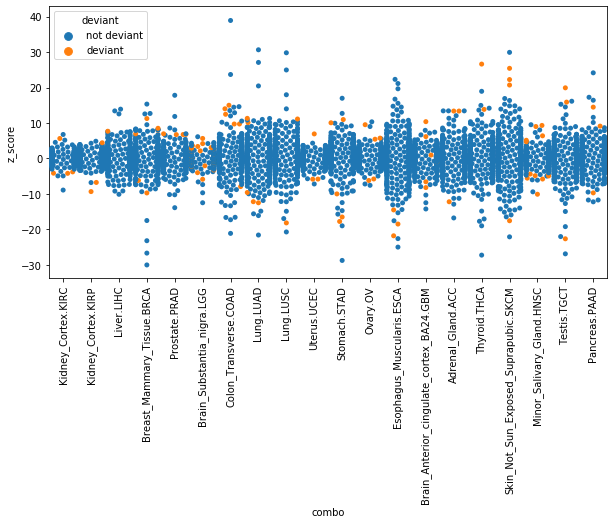

In [96]:
plt.figure(figsize=(10,5)) 
ax = sns.swarmplot(x="combo", y="z_score",hue="deviant",data=compare_beta_annot)
plt.xticks(rotation=90)
plt.savefig("gtex.swarmplot.pdf")

In [97]:
order=[item.get_text() for item in ax.get_xticklabels()]

In [98]:
deviant_counts=compare_beta_annot.groupby(["combo","deviant"]).size().reset_index()

In [99]:
deviant_counts=deviant_counts[deviant_counts["deviant"]=="deviant"]

In [101]:
compare_beta_annot["cancer"]=compare_beta_annot["combo"].str.split(".").str[1]

In [102]:
nml_cancer=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/tcga-normal-cancer-type-beta-se.tsv",delimiter="\t")

In [103]:
nml_cancer=nml_cancer.rename(columns={"file_name":"cancer"})

In [104]:
compare_beta_annot=pd.merge(compare_beta_annot,nml_cancer[["cancer","assoc","BETA","SE"]],on=["cancer","assoc"],how="left")

In [105]:
compare_beta_annot["nml z"]=(compare_beta_annot["BETA_y"]-compare_beta_annot["gtex slope"])/compare_beta_annot["gtex slope_se"]

In [106]:
compare_beta_annot["normal support"]=np.where(abs(compare_beta_annot["nml z"])<abs(compare_beta_annot["z_score"]),"normal","other")

In [107]:
deviant_counts=compare_beta_annot.groupby(["combo","deviant","normal support"]).size().reset_index()

In [108]:
deviant_counts=deviant_counts[deviant_counts["deviant"]=="deviant"]

In [121]:
index=[]
nml_support=[]
no_support=[]

for x in order:
    index.append(x)
    try:
        num=deviant_counts[(deviant_counts["combo"]==x)&(deviant_counts["normal support"]=="other")][0].values[0] 
        no_support.append(num)
    except:
        no_support.append(0)
    
    try:
        num=deviant_counts[(deviant_counts["combo"]==x)&(deviant_counts["normal support"]=="normal")][0].values[0]
        nml_support.append(num)
    except:
        nml_support.append(0)


1
1
2
29
2
4
1
2
2
5
3
6
3
1
4
2
3
3


In [110]:
nml_cancer["cancer"].unique()

array(['BLCA', 'BRCA', 'COAD', 'HNSC', 'KIRC', 'KIRP', 'LIHC', 'LUAD',
       'LUSC', 'PRAD', 'STAD', 'THCA', 'UCEC'], dtype=object)

In [120]:
order

['Kidney_Cortex.KIRC',
 'Kidney_Cortex.KIRP',
 'Liver.LIHC',
 'Breast_Mammary_Tissue.BRCA',
 'Prostate.PRAD',
 'Brain_Substantia_nigra.LGG',
 'Colon_Transverse.COAD',
 'Lung.LUAD',
 'Lung.LUSC',
 'Uterus.UCEC',
 'Stomach.STAD',
 'Ovary.OV',
 'Esophagus_Muscularis.ESCA',
 'Brain_Anterior_cingulate_cortex_BA24.GBM',
 'Adrenal_Gland.ACC',
 'Thyroid.THCA',
 'Skin_Not_Sun_Exposed_Suprapubic.SKCM',
 'Minor_Salivary_Gland.HNSC',
 'Testis.TGCT',
 'Pancreas.PAAD']

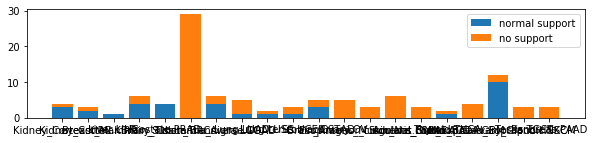

In [117]:
plt.figure(figsize=(10,2)) 
p1 = plt.bar(index, nml_support,label="normal support")
p2 = plt.bar(index, no_support, bottom=nml_support,label="no support")
plt.legend()
plt.savefig("gtex.bar.swarmplot.pdf")

## Plot Venn diagram of deviant snps

In [113]:
deviant_lst=compare_beta_annot[compare_beta_annot["deviant"]=="deviant"]
nml_lst=compare_beta_annot[(compare_beta_annot["deviant"]=="deviant")&(compare_beta_annot["normal support"]=="normal")]
immune_lst=compare_beta_annot[(compare_beta_annot["deviant"]=="deviant")&(compare_beta_annot["immune"]=="not deviant")]
                                                                       
                                                                       

/cellar/users/mpagadal/.local/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


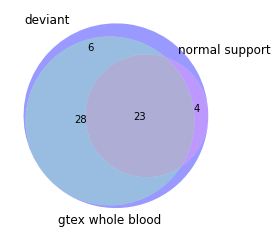

In [114]:
venn3([set(deviant_lst["assoc"].tolist()),set(nml_lst["assoc"].tolist()),set(immune_lst["assoc"].tolist())],
      set_labels=("deviant","normal support","gtex whole blood"), set_colors=["blue","purple","green"])
plt.savefig("gtex.deviant.pie.pdf")

## Get beta plot